In [ ]:
import pandas as pd
import numpy as np

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# Clustering algorithm
from sklearn.cluster import DBSCAN
# Data preprocessing tools
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
# Evaluation metrics
from sklearn.metrics import silhouette_score as ss
from sklearn.metrics import davies_bouldin_score as db_score




In [ ]:
df = pd.read_csv("concert_data.csv", encoding="latin-1")

In [ ]:
df

,city,artist,venue,weekend,pop,month,score,genre,minprice
0,Detroit,Sam Hunt,Ford Field,0,688701,10,76,Country,39.75
1,Minneapolis,Sam Hunt,Target Field,1,400070,7,76,Country,24.75
2,Denver,Sam Hunt,Sports Authority Field At Mile High,1,649495,8,76,Country,29.75
3,Alpharetta,Niall Horan,Verizon Amphitheatre,0,62298,9,78,Rock,47.00
4,Hartford,Sam Hunt,XFINITY Theatre,0,125017,6,76,Country,20.00
...,...,...,...,...,...,...,...,...,...
1193,Mountain View,Logic,Shoreline Amphitheatre,0,77846,7,88,Hip-Hop/Rap,25.00
1194,Denver,Kenny Chesney,Sports Authority Field At Mile High,1,649495,6,76,Country,27.00
1195,Pittsburgh,Ed Sheeran,PNC Park,1,305841,9,94,Pop,39.50
1196,Mansfield,NF,Xfinity Center,0,60872,6,81,Hip-Hop/Rap,25.00


# Data preprocessing

In [ ]:
df['city'] = df['city'].str.replace('Mí©xico', 'Mexico') ## Reformat Mexico

In [ ]:
## Eliminate rows with ??? for population size.
df = df.replace(['NO DATA','N/A', '', '???'],np.nan)

df = df.dropna()
df['minprice'].mean()

52.973007518797

In [ ]:
## Ticket prices range from 1.0 to 2999.0 due to music festivals. To scale this feature,
## I remove all shows with ticket prices over 350. This is about 2 standard deviations above the mean.
for x in df.index:
  if float(df.loc[x, "minprice"]) > 350:
    df.drop(x, inplace=True)
  elif float(df.loc[x, "minprice"]) < 10:
    df.drop(x, inplace=True)

**Creating new features**

In [ ]:
df['genre'].value_counts(ascending=False)

Rock                355
Hip-Hop/Rap         209
Country             182
R&B                  71
Metal                37
Pop                  35
Dance/Electronic     14
Comedy                5
Other                 3
Family                3
Folk                  2
World                 2
Classical             1
Religious             1
Name: genre, dtype: int64

In [ ]:
# Create a new feature from the 'genre' feature. I assign numbers to each
# genre in the order of their popularity, as this is thought to correlate positively
# with the other features (artist popularity, ticket price, city population).

df['genre'].replace(['Religious', 'Classical', 'World', 'Family', 'Folk', 'Other',
                     'Comedy', 'Dance/Electronic', 'Pop', 'Metal', 'R&B', 'Country',
                     'Hip-Hop/Rap','Rock'],
                      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], inplace=True)



## **Feature Scaling**


In [ ]:
## Create scaler object to scale features
scaler = MinMaxScaler()

In [ ]:
# Here I scale all of my numeric features that I plan to use in my analysis.

numeric_features_list = ['score', 'minprice', 'pop', 'genre']

scaler.fit(df[numeric_features_list])
df[numeric_features_list] = scaler.transform(df[numeric_features_list])


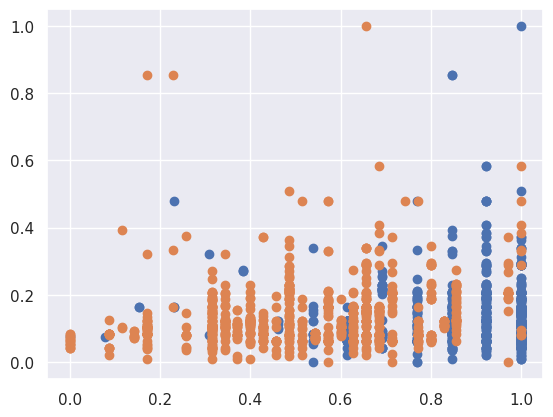

In [202]:
plt.scatter(df['genre'], df['minprice'])
plt.scatter(df['score'], df['minprice'])


## While there is a slight visible positive correlation across my features, there is still
## a lot of noise and outliers. This leads me to believe that a density based clustering
## algorithm would be better suited to finding meaningful clusters.

In [ ]:
# PCA

In [ ]:
pca_features_list = ['pop', 'minprice', 'genre', 'score']

In [ ]:
pca = PCA()

In [ ]:
pca.fit(df[pca_features_list])

PCA()

In [ ]:
# Seeing which features account for most variance.
pca.explained_variance_ratio_

array([0.4593428 , 0.29033053, 0.17758882, 0.07273786])

In [ ]:
# The first 2 components explain around 75% of the variance, so I keep these.
pca = PCA(n_components=2)
pca.fit(df[numeric_features_list])
pca_scores = pca.transform(df[numeric_features_list])

# Level 2: Building and Training model

In [ ]:
## Model Building using PCA scores

In [ ]:
dbscan = DBSCAN(eps=.105, min_samples=5)
dbscan.fit(pca_scores)


DBSCAN(eps=0.105)

In [ ]:
# Creating new df with Component values columns.
df_dbscan = pd.concat([df.reset_index(drop=True),
                           pd.DataFrame(pca_scores)], axis=1)

# I make 2 new columns for the component scores and add them to the df.
df_dbscan.columns.values[-2: ] = ['Component 1', 'Component 2']
# Add cluster labels to df.
df_dbscan['Concert DBSCAN PCA Cluster'] = dbscan.labels_

## Visualizing the concert data using Components 1 and 2.


<ipython-input-151-84de3a49b7bb>:8: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x=x_axis, y=y_axis, hue=df_dbscan['Concert DBSCAN PCA Cluster'],


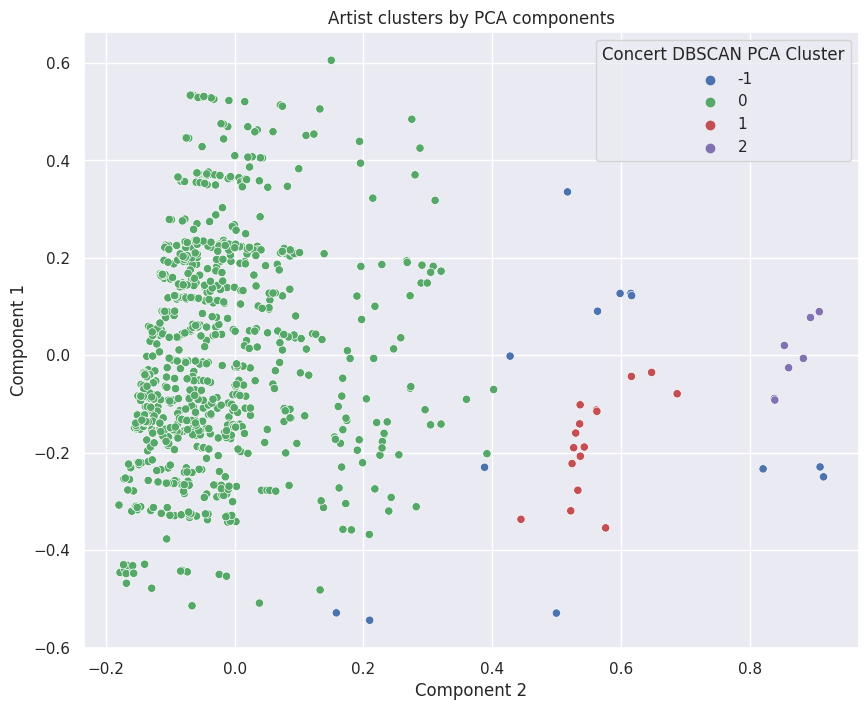

In [ ]:
## ## Create separate dfs from clusters.

x_axis = df_dbscan['Component 2']
y_axis = df_dbscan['Component 1']

plt.figure(figsize = (10, 8))

sns.scatterplot(x=x_axis, y=y_axis, hue=df_dbscan['Concert DBSCAN PCA Cluster'],
                palette=['b', 'g', 'r', 'm', 'c'])

plt.title("Artist clusters by PCA components")
plt.show()

<ipython-input-152-076c2f0d2a1f>:17: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x=x_axis, y=y_axis, hue=df_dbscan['Concert DBSCAN PCA Cluster'],


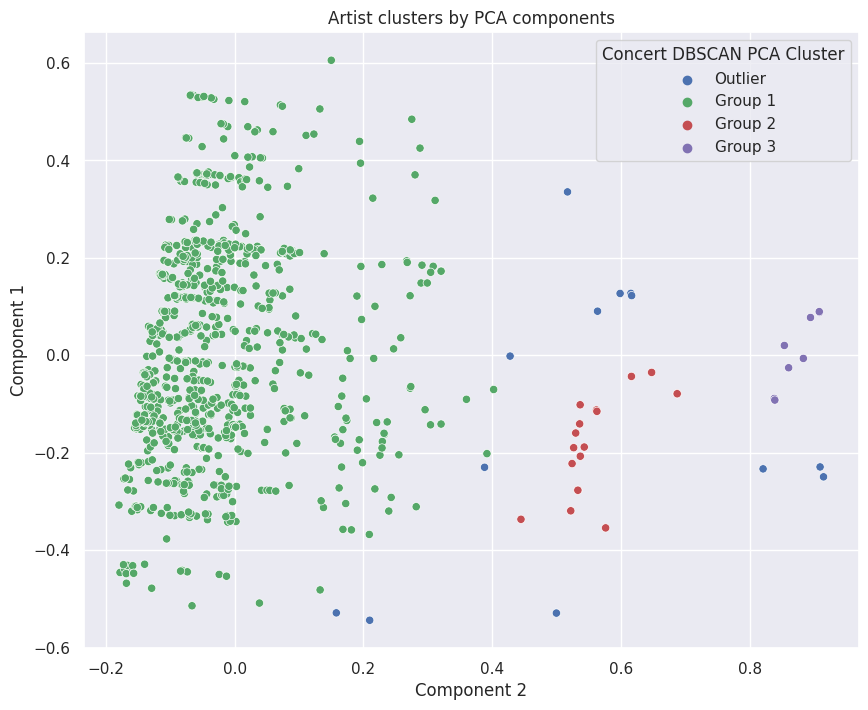

In [ ]:
# Lastly, I rename the cluster labels in the df to descriptive titles.
## ('Group 1', 'Group 2')
mapping = {
    0: 'Group 1',
    1: 'Group 2',
    2: 'Group 3',
    -1: 'Outlier',
}

df_dbscan['Concert DBSCAN PCA Cluster'] = df_dbscan['Concert DBSCAN PCA Cluster'].astype('category').cat.rename_categories(mapping)

x_axis = df_dbscan['Component 2']
y_axis = df_dbscan['Component 1']

plt.figure(figsize = (10, 8))

sns.scatterplot(x=x_axis, y=y_axis, hue=df_dbscan['Concert DBSCAN PCA Cluster'],
                palette=['b', 'g', 'r', 'm', 'c'])

plt.title("Artist clusters by PCA components")
plt.show()

# **Analysis of clusters**

In [ ]:
df_dbscan[df_dbscan['Concert DBSCAN PCA Cluster'] == 'Group 1'].describe()

,weekend,pop,month,score,genre,minprice,Component 1,Component 2
count,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000
mean,0.437358,0.087175,7.776765,0.525805,0.889872,0.132137,0.006272,-0.030212
std,0.496343,0.099548,1.790717,0.218829,0.135554,0.090533,0.220064,0.103039
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-0.513836,-0.179863
25%,0.000000,0.009871,7.000000,0.342857,0.846154,0.081250,-0.148262,-0.100930
50%,0.000000,0.056537,8.000000,0.542857,0.923077,0.106250,-0.017239,-0.056926
75%,1.000000,0.134797,9.000000,0.685714,1.000000,0.164583,0.169598,0.006845
max,1.000000,0.561032,12.000000,1.000000,1.000000,1.000000,0.605726,0.402263


Group 1 encompasses the majority of concerts, especially those with high minimum prices. These concerts were in small to mid-size cities/towns (mean city population is .087). High prices account for much of the variance in Group 1; the mean normalized price is .13, but the max is 1.

In [ ]:
df_dbscan[df_dbscan['Concert DBSCAN PCA Cluster'] == 'Group 2'].describe()

,weekend,pop,month,score,genre,minprice,Component 1,Component 2
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,0.333333,0.689421,7.833333,0.636508,0.782051,0.125465,-0.179580,0.561444
std,0.485071,0.032042,1.543487,0.098880,0.258850,0.050420,0.100805,0.061839
min,0.000000,0.561032,6.000000,0.514286,0.230769,0.037000,-0.353998,0.444732
25%,0.000000,0.696973,6.250000,0.571429,0.615385,0.082552,-0.263045,0.530618
50%,0.000000,0.696973,8.000000,0.614286,0.923077,0.118750,-0.173700,0.536797
75%,1.000000,0.696973,8.750000,0.700000,0.980769,0.164583,-0.104012,0.572876
max,1.000000,0.696973,11.000000,0.828571,1.000000,0.206250,-0.034913,0.687426


Concerts in group 2 were low in the minprice feature, and tended to be lower in the genre feature (meaning they were *not* pop, country, rock, and hip-hop shows). Group 2 is also distinct in that the mean city population is much higher than group 1 (.68 vs. .087).

In [ ]:
df_dbscan[df_dbscan['Concert DBSCAN PCA Cluster'] == 'Group 3'].describe()

,weekend,pop,month,score,genre,minprice,Component 1,Component 2
count,10.000000,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.300000,1.000000e+00,7.600000,0.397143,0.915385,0.133958,-0.000653,0.868000
std,0.483046,1.170278e-16,1.074968,0.071840,0.098976,0.047475,0.073061,0.028298
min,0.000000,1.000000e+00,6.000000,0.314286,0.769231,0.072917,-0.091647,0.838294
25%,0.000000,1.000000e+00,7.000000,0.328571,0.846154,0.112500,-0.072648,0.842850
50%,0.000000,1.000000e+00,8.000000,0.385714,0.961538,0.112500,0.007094,0.857298
75%,0.750000,1.000000e+00,8.000000,0.471429,1.000000,0.163021,0.063467,0.891801
max,1.000000,1.000000e+00,9.000000,0.485714,1.000000,0.207292,0.089852,0.908618


Group 3 consisted of concerts that were in major cities, as shown by the population
feature being 1 for all data points. Out of all groups, the genre feature is also most consisently high, with standard deviation of .09 (compared to 0.26 and .13)

# **Level 3: Evaluating model using Silhouette Coefficient**

In [ ]:
# Since DBSCAN takes 2 parameters, I use a nested for loop to test
# a series of possible parameter combinations, and see which results in the highest
# Silhouette Score.

best_score = -1  # Initialize a best score variable to update throughout loop
best_params = {}

for eps_value in [0.05, 0.08, 0.105, 0.12]:
    for min_samples_value in [2, 3, 4, 5, 10]:
        dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
        labels = dbscan.fit_predict(pca_scores)
        score = ss(pca_scores, labels)

        if score > best_score:
                best_score = score
                best_params['eps'] = eps_value
                best_params['min_samples'] = min_samples_value

print("Best Parameters:", best_params)
print("Best Silhouette Score:", best_score)
# I passed these parameters into my original DBSCAN model in Level 2.

Best Parameters: {'eps': 0.105, 'min_samples': 5}
Best Silhouette Score: 0.5284236105949723


In [ ]:
# Calculating DBCV score (Density-based clustering valuation score)

In [ ]:
dbscan = DBSCAN(eps=.105, min_samples=5)
labels = dbscan.fit_predict(pca_scores)

davies_bouldin_score = db_score(pca_scores, labels)
davies_bouldin_score



11.880387550130331